In [31]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS

#### To do : Function : 
Parameters : 
- City - remove - and redo chebyshev polynomials
- 3 degree bin , 5 degree bin
- outcome variable  -> if clause adapt 
- tmean , tmax_obs -> add climate data later first tmax_obs : including different naming
- temp bin size: 

Linear Fare

In [59]:

city = "CHI"

## 1. DATA PREPARATION

if city == "NYC":
        taxi_data_cut = pd.read_csv('Pooled_data/data_regression_PU.csv')
elif city == "DC":
        taxi_data_cut = pd.read_csv('DC_data/DC_regression_zipcodes.csv')
elif city == "CHI":
        taxi_data_cut = pd.read_csv('Chigaco_data/chicago_PU_regression_censustract.csv') 


# Arrange the temperature bins
sequence_bins = np.arange(-10, 41, temp_bin_size)
temp_bins = pd.cut(taxi_data_cut['tmax_obs'], bins=sequence_bins, include_lowest=True, ordered = True)
taxi_data_cut['temp_bins'] = temp_bins

# rename bins so linearmodels can handle them

taxi_data_cut['temp_bins'] = pd.Categorical(taxi_data_cut['temp_bins'], ordered=False).astype(str)
# rename bins so linearmodels can handle them
taxi_data_cut['temp_bins'] = taxi_data_cut['temp_bins'].str.replace('\(', '[', regex=True)
# Create a panel data structure
panel_data = taxi_data_cut.set_index([ 'PULocationID', 'Year_fact'])
panel_data = panel_data[panel_data['temp_bins'] != 'nan']


# For plotting and ommitting the bin with highest number of days

# Create a new DataFrame with unique days
unique_days = taxi_data_cut[['date_pickup', 'temp_bins']].drop_duplicates()

# Count the occurrences of each bin, respecting the categorical order
temp_bin_counts = unique_days['temp_bins'].value_counts().sort_index()

# Only plot bins with more than one day
temp_bin_counts = temp_bin_counts[temp_bin_counts > 1]
# Find the index of the maximum count
max_days_bin = temp_bin_counts.idxmax()

##  2. REGRESSIONS

if city == 'NYC' :

        model_formula = f'trip_distance_mean~  1+ tmax_obs + pr_obs + Snowdepth  + windspeed_obs + Weekday_index + holiday +cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + EntityEffects + TimeEffects'
        model = PanelOLS.from_formula(model_formula, data=panel_data)
        results = model.fit(cov_type='clustered', cluster_entity=True)
                

if city == "DC" :
        
        panel_data = panel_data[panel_data['average_mileage'] != 0]
        model_formula = f'average_mileage ~ 1+  tmax_obs + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
        model = PanelOLS.from_formula(model_formula, data=panel_data)
        results = model.fit(cov_type='clustered', cluster_entity=True)
        
if city == "CHI":

        
        model_formula = f'avg_trip_miles ~ 1+  tmax_obs + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
        model = PanelOLS.from_formula(model_formula, data=panel_data)
        results = model.fit(cov_type='clustered', cluster_entity=True)

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [60]:
results.summary

Dep. Variable:,avg_trip_miles,R-squared:,0.0030
Estimator:,PanelOLS,R-squared (Between):,-0.0425
No. Observations:,271009,R-squared (Within):,0.0055
Date:,"Sun, Dec 10 2023",R-squared (Overall):,0.0055
Time:,17:56:38,Log-likelihood,-8.182e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,82.523
Entities:,1235,P-value,0.0000
Avg Obs:,219.44,Distribution:,"F(10,269760)"
Min Obs:,1.0000,,
Max Obs:,1789.0,F-statistic (robust):,32.551


Linear Distanz Regression

In [62]:
def binned_regression_plots(city,outcome,temp_bin_size):
        
        ## 1. DATA PREPARATION

        if city == "NYC":
                taxi_data_cut = pd.read_csv('Pooled_data/data_regression_PU.csv')
        elif city == "DC":
                taxi_data_cut = pd.read_csv('DC_data/DC_regression_zipcodes.csv')
        elif city == "CHI":
                taxi_data_cut = pd.read_csv('Chigaco_data/chicago_PU_regression_censustract.csv') 


        sequence_bins = np.arange(-10, 41, temp_bin_size)
        temp_bins = pd.cut(taxi_data_cut['tmax_obs'], bins=sequence_bins, include_lowest=True, ordered = True)
        taxi_data_cut['temp_bins'] = temp_bins



        # rename bins so linearmodels can handle them

        taxi_data_cut['temp_bins'] = pd.Categorical(taxi_data_cut['temp_bins'], ordered=False).astype(str)
        # rename bins so linearmodels can handle them
        taxi_data_cut['temp_bins'] = taxi_data_cut['temp_bins'].str.replace('\(', '[', regex=True)
        # Create a panel data structure
        panel_data = taxi_data_cut.set_index([ 'PULocationID', 'Year_fact'])
        panel_data = panel_data[panel_data['temp_bins'] != 'nan']


        # For plotting and ommitting the bin with highest number of days

        # Create a new DataFrame with unique days
        unique_days = taxi_data_cut[['date_pickup', 'temp_bins']].drop_duplicates()

        # Count the occurrences of each bin, respecting the categorical order
        temp_bin_counts = unique_days['temp_bins'].value_counts().sort_index()

        # Only plot bins with more than one day
        temp_bin_counts = temp_bin_counts[temp_bin_counts > 1]
        # Find the index of the maximum count
        max_days_bin = temp_bin_counts.idxmax()

        ##  2. REGRESSIONS

        if city == 'NYC' :
                if outcome == "trip_number":
                        model_formula = f'log_total~  1+ C(temp_bins, Treatment(reference = "{max_days_bin}")) + pr_obs + Snowdepth + windspeed_obs + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)
                        # get temperature bin with highest number of days
                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                        # if all of the coefficients are negative, max_bin = max_days_bin
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        # else the max_bin is the one with the highest coefficient
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'
                        
                        # Redo regression with maximum bin omitted
                        model_formula = f'log_total~  1+ C(temp_bins, Treatment(reference = "{max_bin}")) + pr_obs + Snowdepth  + windspeed_obs + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                elif outcome == "trip_distance_mean":
                        model_formula = f'trip_distance_mean~  1+ C(temp_bins, Treatment(reference = "{max_days_bin}")) + pr_obs + Snowdepth  + windspeed_obs + Weekday_index + holiday +cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'
                        
                        model_formula = f'trip_distance_mean~  1+ C(temp_bins, Treatment(reference = "{max_bin}")) + pr_obs + Snowdepth  + windspeed_obs + Weekday_index + holiday +cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)
                        
                elif outcome == "mean_fare":
                        # replace uber distance with taxi distance
                        panel_data["total_amount_mean"] = panel_data['total_amount_mean'].fillna(panel_data['base_fare_mean'])
                        model_formula = f'total_amount_mean~  1+ C(temp_bins, Treatment(reference = "{max_days_bin}")) + pr_obs +Snowdepth  + windspeed_obs + Weekday_index + holiday  +cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)
                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'
                        
                        model_formula = f'total_amount_mean~  1+ C(temp_bins, Treatment(reference = "{max_bin}")) + pr_obs +Snowdepth  + windspeed_obs + Weekday_index + holiday  +cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)
                
        if city == "DC" :
                if outcome == "trip_number":
                        model_formula = f'log_total ~ 1+  C(temp_bins, Treatment(reference = "{max_days_bin}")) + PRCP + AWND + Weekday_index + holiday  + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'

                        model_formula = f'log_total ~ 1+  C(temp_bins, Treatment(reference = "{max_bin}")) + PRCP + AWND + Weekday_index + holiday  + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                if outcome == "trip_distance_mean":
                        panel_data = panel_data[panel_data['average_mileage'] != 0]
                        model_formula = f'average_mileage ~ 1+  C(temp_bins, Treatment(reference = "{max_days_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'
                        
                        panel_data = panel_data[panel_data['average_mileage'] != 0]
                        model_formula = f'average_mileage ~ 1+  C(temp_bins, Treatment(reference = "{max_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                if outcome == "mean_fare":
                        model_formula = f'average_totalamount ~ 1+  C(temp_bins, Treatment(reference = "{max_days_bin}")) + PRCP + AWND + Weekday_index + holiday  + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'

                        model_formula = f'average_totalamount ~ 1+  C(temp_bins, Treatment(reference = "{max_bin}")) + PRCP + AWND + Weekday_index + holiday  + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                
        if city == "CHI":
                if outcome == "trip_number":
                        model_formula = f'log_total ~ 1+  C(temp_bins, Treatment(reference = "{max_days_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'
                        
                        model_formula = f'log_total ~ 1+  C(temp_bins, Treatment(reference = "{max_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                if outcome == "trip_distance_mean":
                        model_formula = f'avg_trip_miles ~ 1+  C(temp_bins, Treatment(reference = "{max_days_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'
                        
                        model_formula = f'avg_trip_miles ~ 1+  C(temp_bins, Treatment(reference = "{max_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                if outcome == "mean_fare":
                        model_formula = f'avg_fare ~ 1+  C(temp_bins, Treatment(reference = "{max_days_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'
                        
                        model_formula = f'avg_fare ~ 1+  C(temp_bins, Treatment(reference = "{max_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                if outcome == "mean_tip":
                        model_formula = f'avg_tips ~ 1+  C(temp_bins, Treatment(reference = "{max_days_bin}")) + PRCP + AWND + Weekday_index +avg_fare +avg_trip_miles+ holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
                        model = PanelOLS.from_formula(model_formula, data=panel_data)
                        results = model.fit(cov_type='clustered', cluster_entity=True)

                        co = pd.DataFrame(results.params)
                        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]
                
                        if all(coefficients_temp_bins.parameter < 0):
                                max_bin = max_days_bin
                        
                        else:
                                max_id = coefficients_temp_bins.parameter.idxmax()
                                parts = max_id.split('[T.')
                                max_bin = parts[1].split(']')[0] + ']'
        

        ## 3. PLOTS

        coefficients = results.params
        conf_int = results.conf_int()

        # Combine coefficients and confidence intervals into a single DataFrame
        df = pd.DataFrame(pd.concat([coefficients, conf_int], axis=1))
        df.columns = ['Coefficient', 'Lower CI', 'Upper CI']
        df.reset_index(inplace=True)

        # only keep rows where index starts with C(temp_bins)
        df = df[df['index'].str.startswith('C(temp_bins')]

        # extract temperature bin string

        df['Temperature'] = df['index'].str.split(r'\[T\.').str[1].str[:-1]

        df.drop(columns=['index'], inplace=True)

        # Convert Temperature intervals into numerical values
        df['Temperature'] = df['Temperature'].str.strip('[]').str.split(',').apply(lambda x: (float(x[0]) + float(x[1])) / 2)
        # order the dataframe by temperature
        df = df.sort_values(by=['Temperature'])

        # convert the coeffients into percentages and adapt CI accordingly - only with log outcome
        if outcome == "trip_number":
                df['Coefficient'] = df['Coefficient'] * 100
                df['Lower CI'] = df['Lower CI'] * 100
                df['Upper CI'] = df['Upper CI'] * 100

        # Extract Temperature and Coefficient values
        temperature = df['Temperature']
        coefficient = df['Coefficient']

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

        # Create the plot

        ax1.scatter(temperature, coefficient, color='blue', label='Data')
        if outcome == "trip_number":    
                ax1.set_ylabel(f'{outcome} response in %')
        else:
                ax1.set_ylabel(f'{outcome} response in $')
        
        ax1.set_title(f'{outcome} response by {temp_bin_size}°C bin- {city}- {max_bin} omitted')

        # Add confidence intervals if needed
        lower_ci = df['Lower CI']
        upper_ci = df['Upper CI']
        ax1.errorbar(temperature, coefficient, yerr=[coefficient - lower_ci, upper_ci - coefficient], fmt='o', color='red' , capsize= 3,  barsabove = True , label='Confidence Interval')

        # Fit a polynomial
        degree = 2
        coefficients_poly = np.polyfit(temperature, coefficient, degree)
        y_poly = np.polyval(coefficients_poly, temperature)

        # Plot the polynomial curve
        ax1.plot(temperature, y_poly, label=f'Polynomial Fit (Degree {degree})', color='green')

        # add a dotted line at 0 percent
        ax1.axhline(y=0, color='blue', linestyle='--')

        # Add a legend
        ax1.legend()


        sequence_bins = np.arange(-10, 41, temp_bin_size)
        temp_bins = pd.cut(taxi_data_cut['tmax_obs'], bins=sequence_bins, include_lowest=True, ordered = True)
        taxi_data_cut['temp_bins'] = temp_bins
        # Create a new DataFrame with unique days
        unique_days = taxi_data_cut[['date_pickup', 'temp_bins']].drop_duplicates()

        # Count the occurrences of each bin, respecting the categorical order
        temp_bin_counts = unique_days['temp_bins'].value_counts().sort_index()
        temp_bin_counts = temp_bin_counts[temp_bin_counts > 1]
        # Find the index of the maximum count
        max_days_bin = temp_bin_counts.idxmax()

        # Create a color array with 'grey' for all bars and 'red' for the bar with the maximum count
        color_bin= '(' + max_bin[1:]
        colors = ['grey' if str(bin) != color_bin else 'red' for bin in temp_bin_counts.index]

        # Ensure the plot respects the categorical order
        temp_bin_counts.plot(kind='bar', color=colors)
        ax2.set_title(f' Days in each {temp_bin_size}°C bin- {city} 2014-2019')
        ax2.set_xlabel('Temperature Bins')
        ax2.set_ylabel('Number of Days')
        ax2.tick_params(axis='x', rotation=45)
        plt.savefig(f'Figures/Figures_11_12/{city}_{outcome}_{temp_bin_size}_degree.png')
        print(results.summary)
        print(f"Done: {city} {outcome} {temp_bin_size}")

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               avg_tips   R-squared:                        0.0159
Estimator:                   PanelOLS   R-squared (Between):             -0.0110
No. Observations:              271009   R-squared (Within):               0.0177
Date:                Tue, Dec 12 2023   R-squared (Overall):              0.0348
Time:                        16:11:44   Log-likelihood                 -5.09e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      173.98
Entities:                        1235   P-value                           0.0000
Avg Obs:                       219.44   Distribution:               F(25,269745)
Min Obs:                       1.0000                                           
Max Obs:                       1789.0   F-statistic (robust):             8.5801
                            

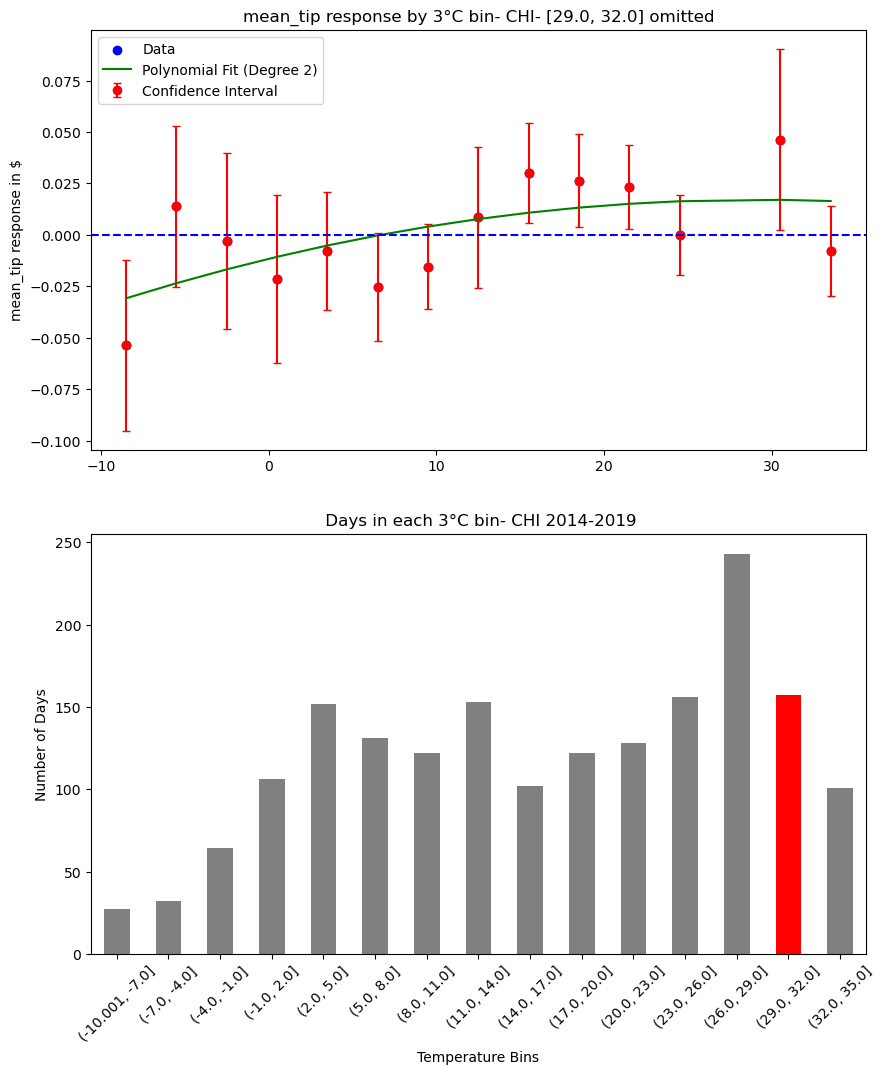

In [63]:
binned_regression_plots("CHI","mean_tip",3)

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: NYC trip_number 3


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: NYC trip_number 5


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: NYC trip_distance_mean 3


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: NYC trip_distance_mean 5


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: NYC mean_fare 3


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: NYC mean_fare 5


C:\Users\max-admin\AppData\Local\Temp\ipykernel_5304\1919609481.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi_data_cut = pd.read_csv('DC_data/DC_regression_zipcodes.csv')


Done: DC trip_number 3


C:\Users\max-admin\AppData\Local\Temp\ipykernel_5304\1919609481.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi_data_cut = pd.read_csv('DC_data/DC_regression_zipcodes.csv')


Done: DC trip_number 5


C:\Users\max-admin\AppData\Local\Temp\ipykernel_5304\1919609481.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi_data_cut = pd.read_csv('DC_data/DC_regression_zipcodes.csv')


Done: DC trip_distance_mean 3


C:\Users\max-admin\AppData\Local\Temp\ipykernel_5304\1919609481.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi_data_cut = pd.read_csv('DC_data/DC_regression_zipcodes.csv')


Done: DC trip_distance_mean 5


C:\Users\max-admin\AppData\Local\Temp\ipykernel_5304\1919609481.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi_data_cut = pd.read_csv('DC_data/DC_regression_zipcodes.csv')


Done: DC mean_fare 3


C:\Users\max-admin\AppData\Local\Temp\ipykernel_5304\1919609481.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi_data_cut = pd.read_csv('DC_data/DC_regression_zipcodes.csv')


Done: DC mean_fare 5


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: CHI trip_number 3


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: CHI trip_number 5


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: CHI trip_distance_mean 3


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: CHI trip_distance_mean 5


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: CHI mean_fare 3


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Done: CHI mean_fare 5


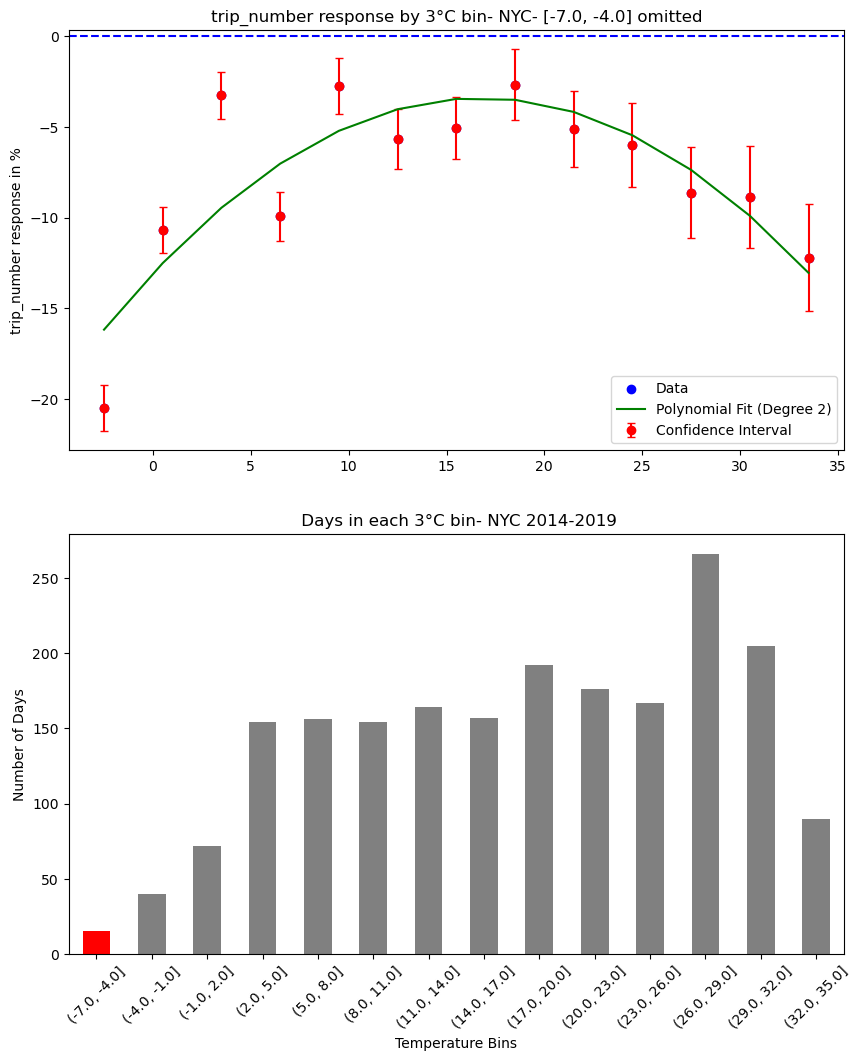

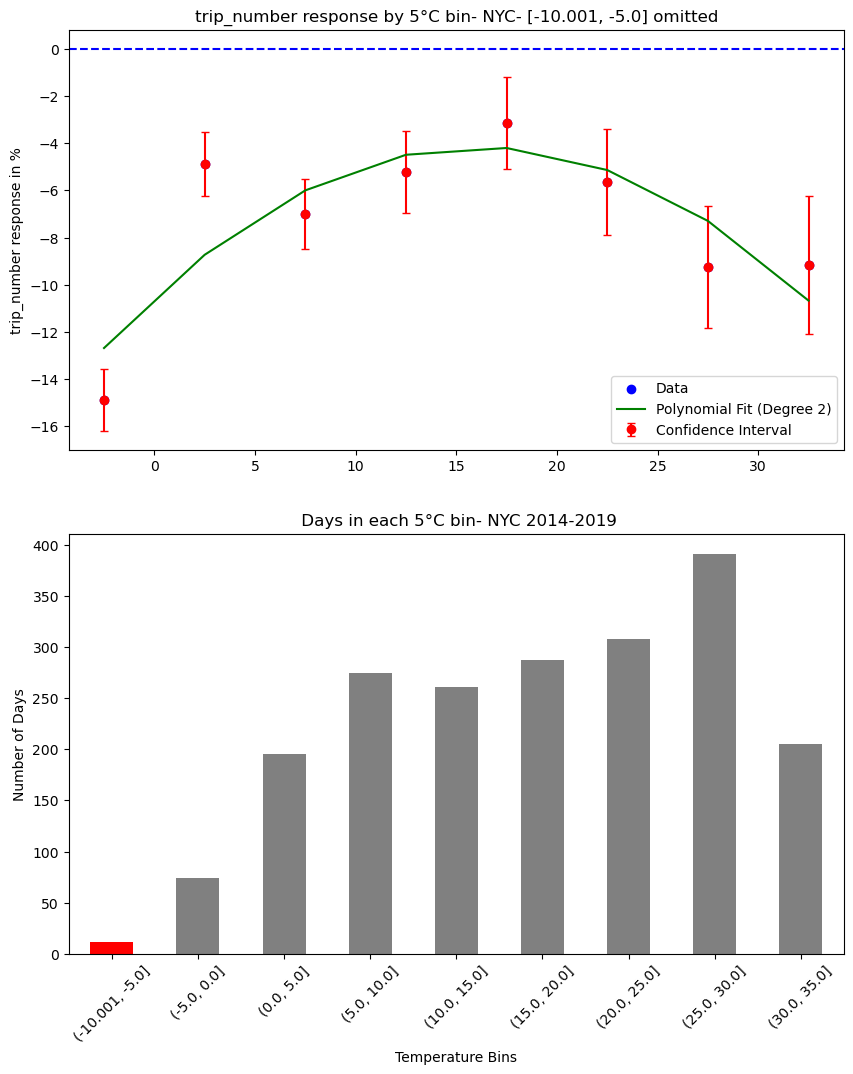

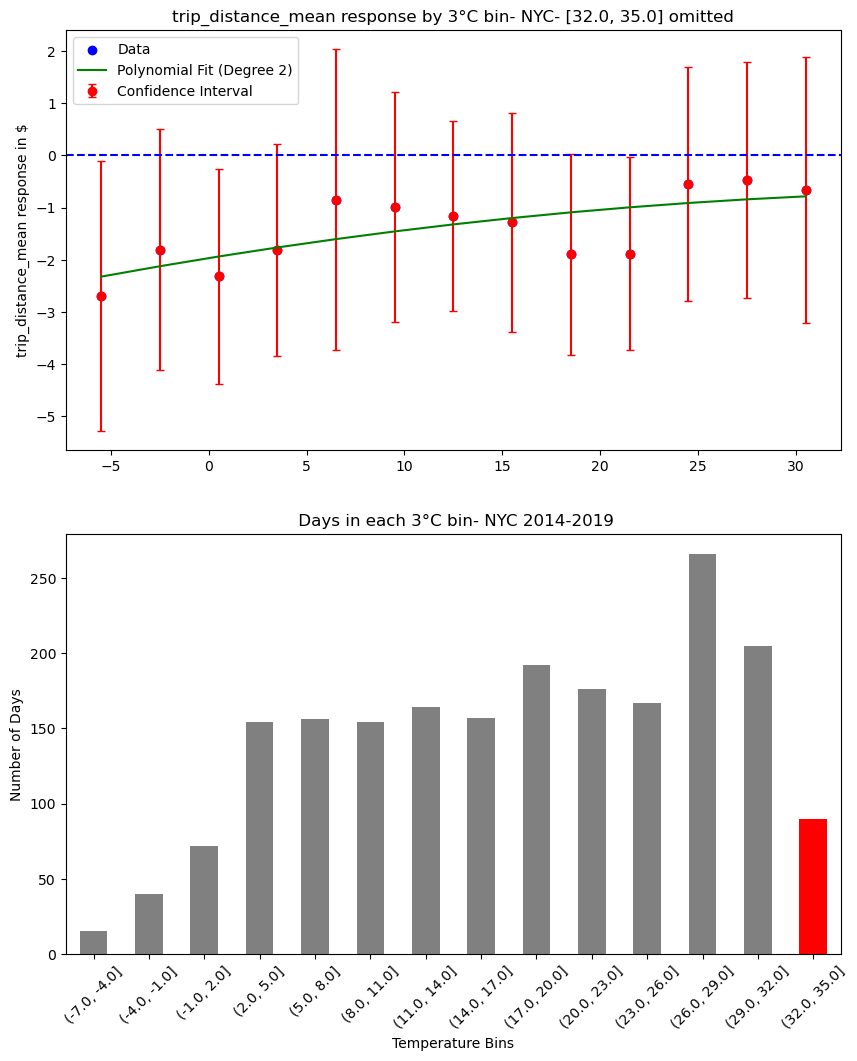

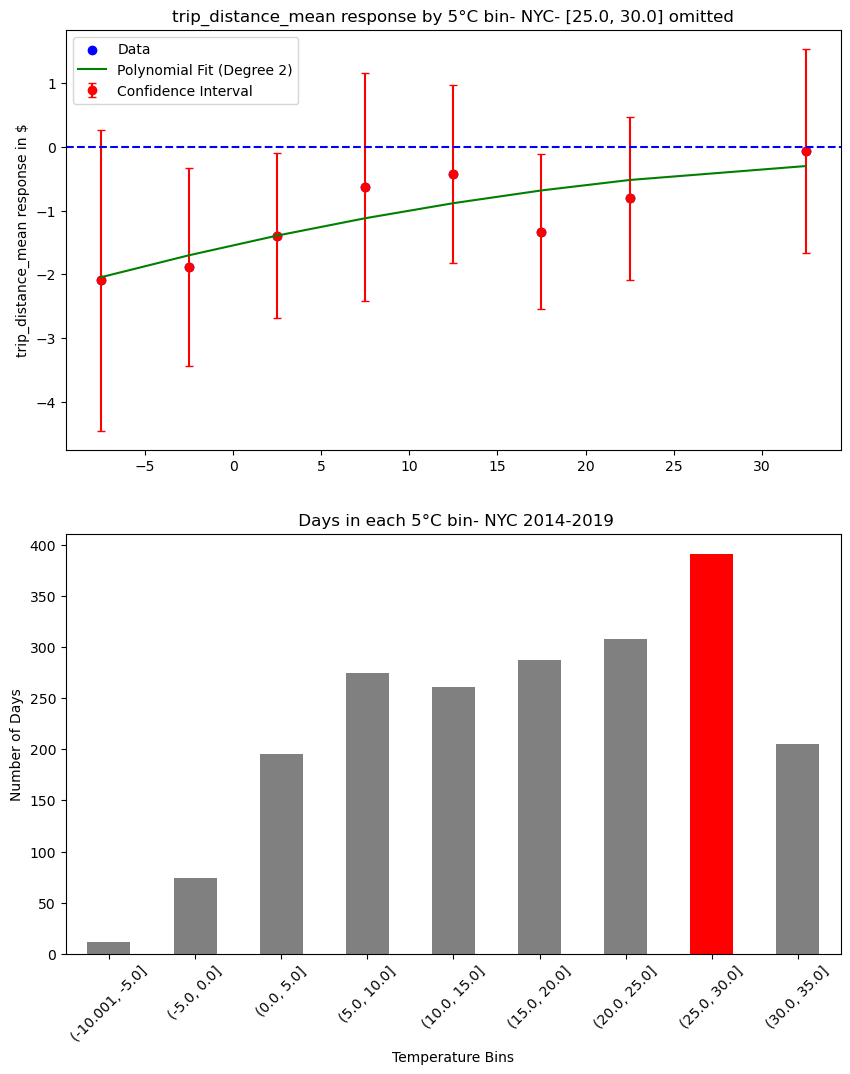

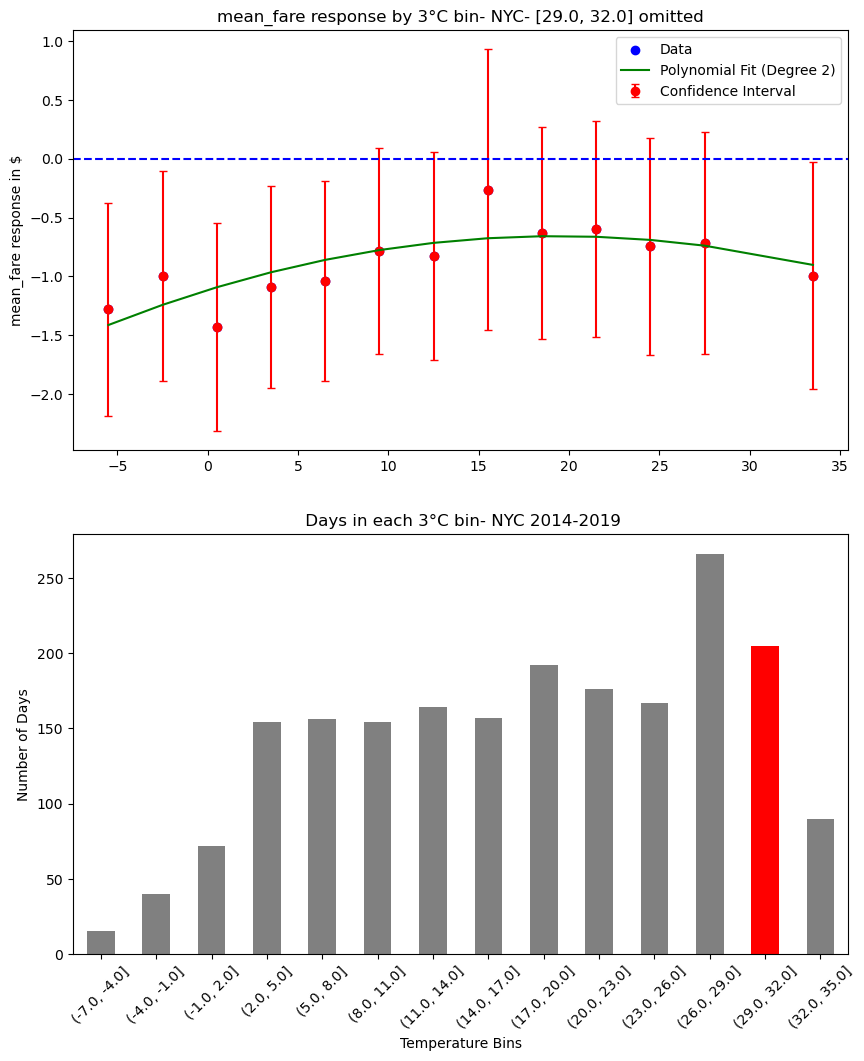

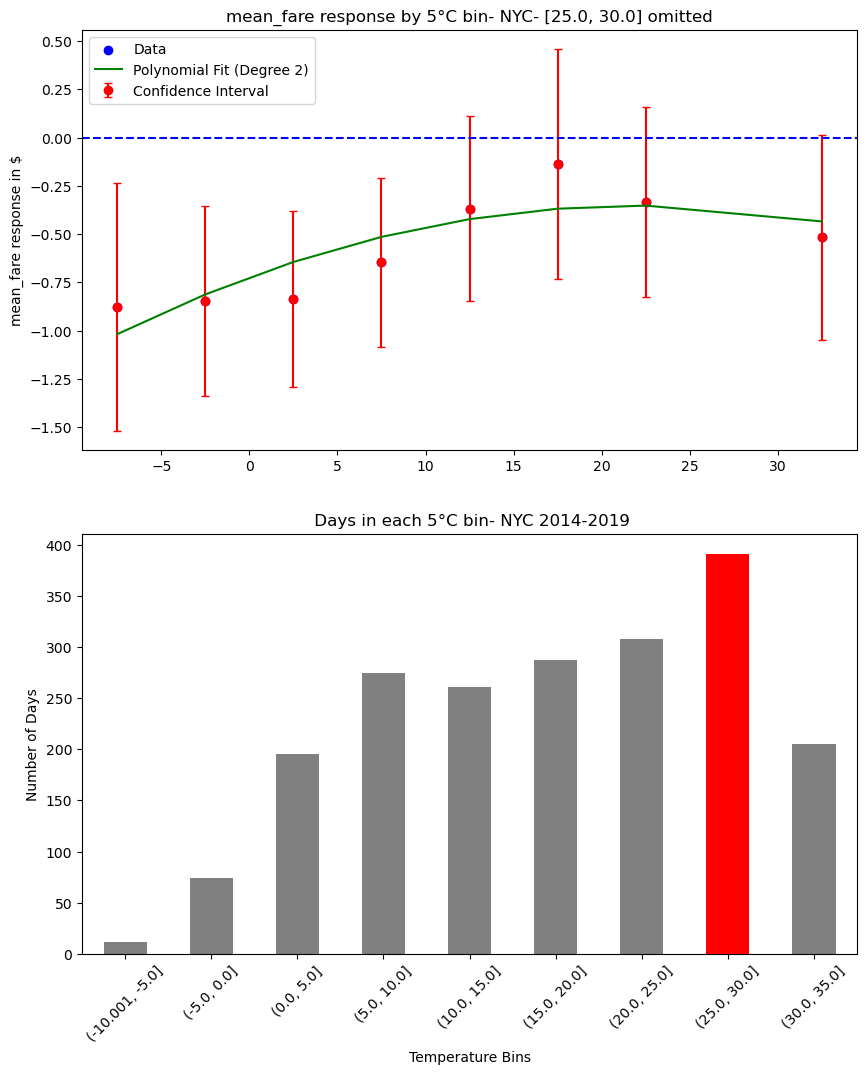

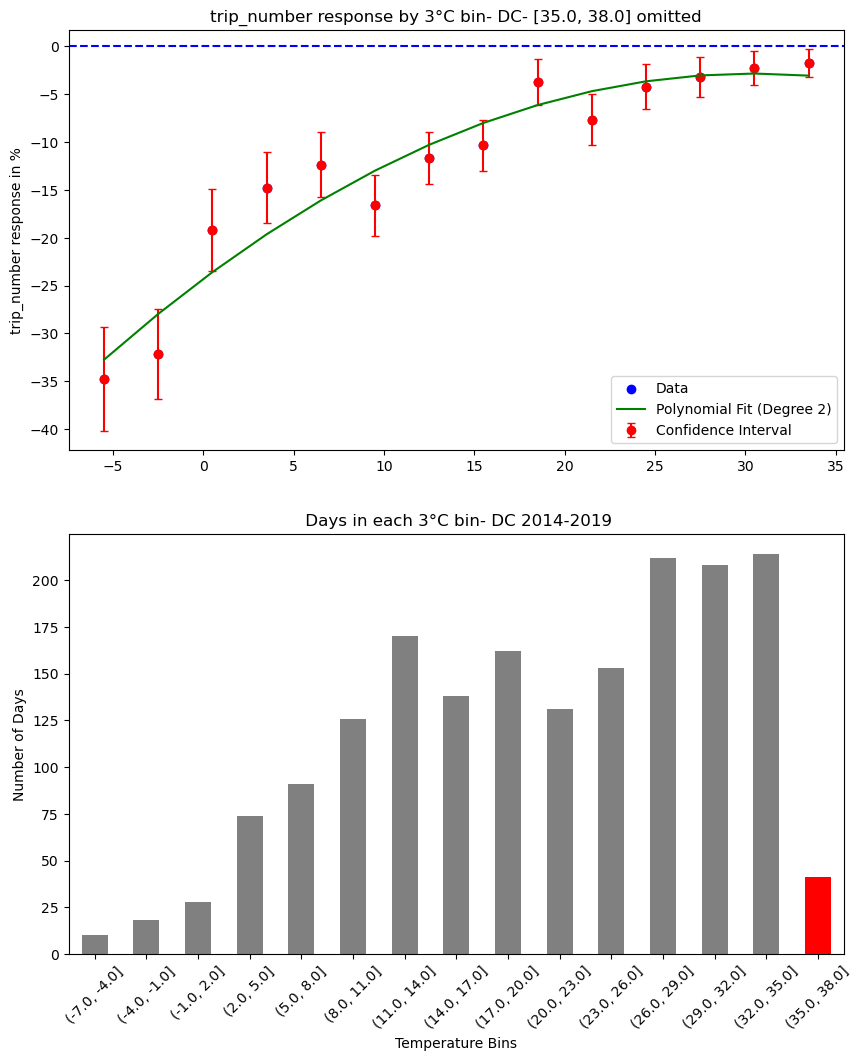

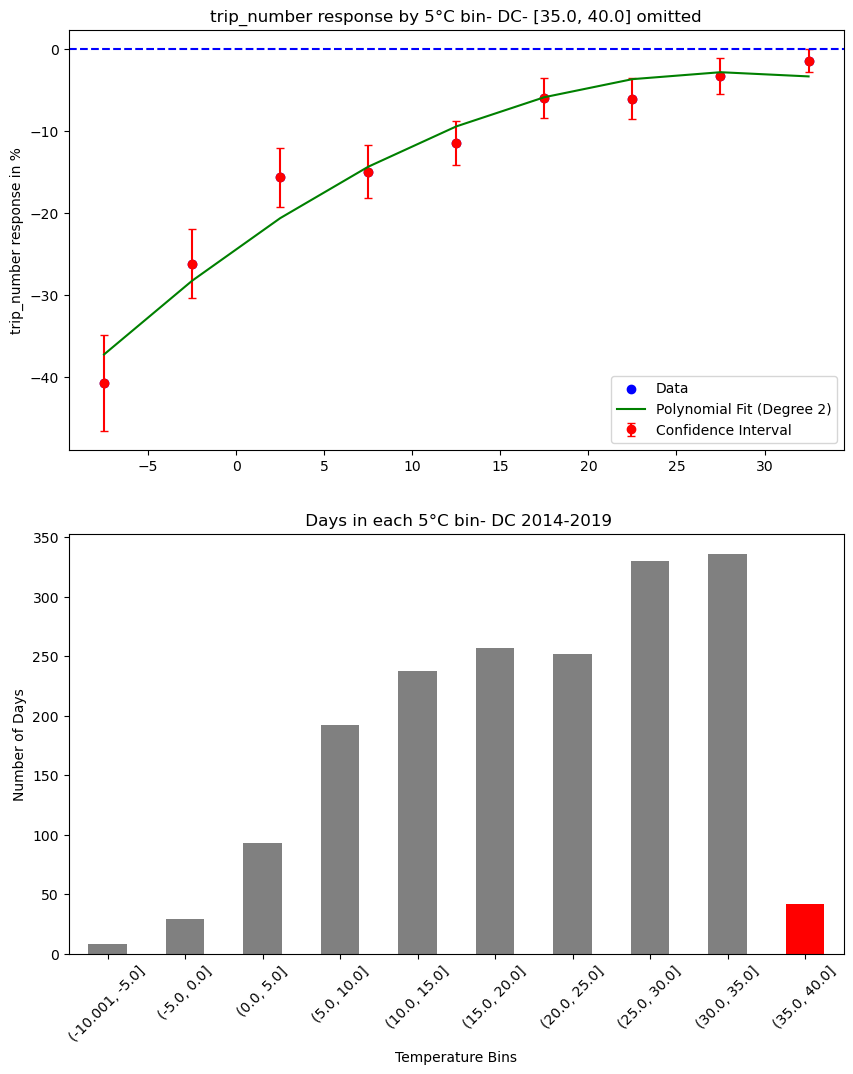

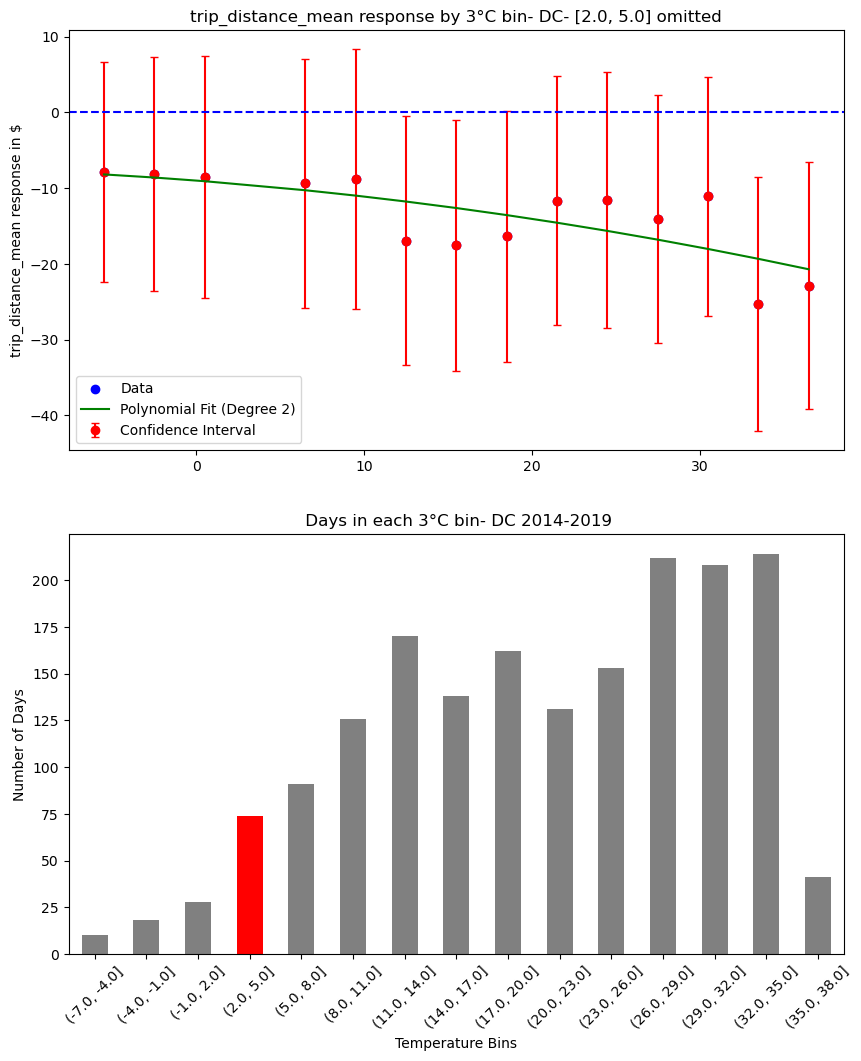

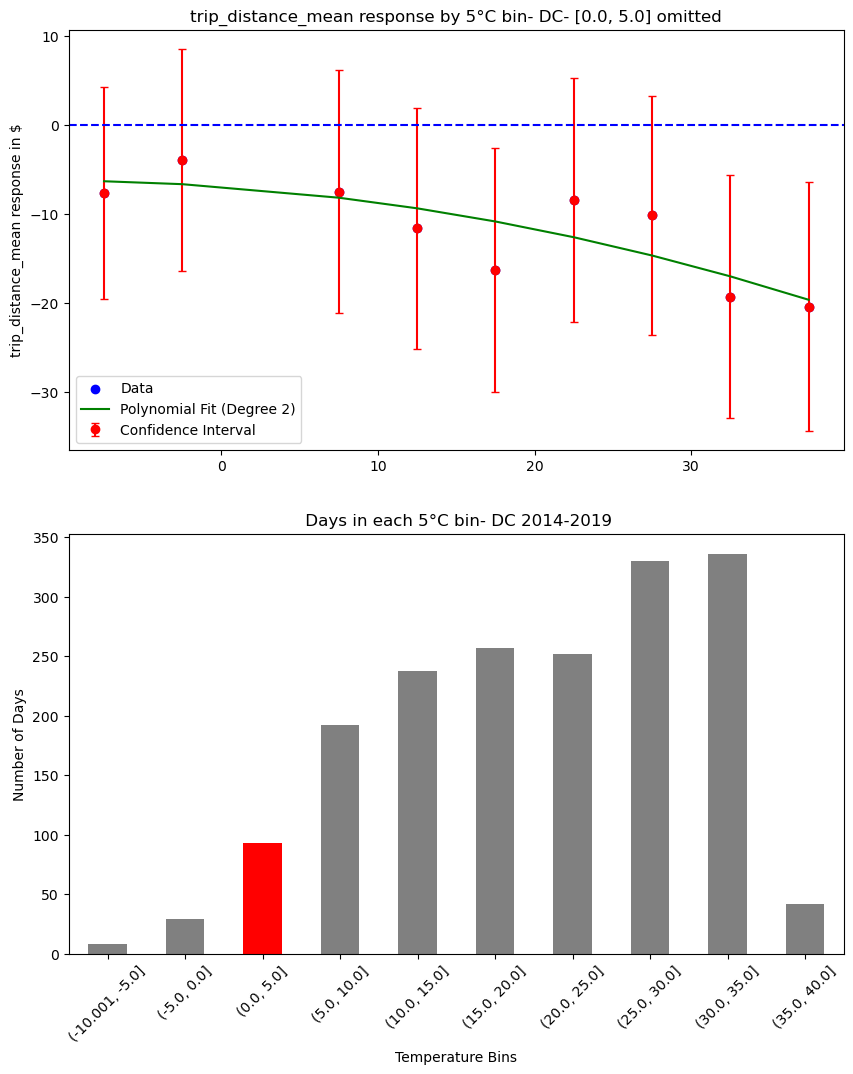

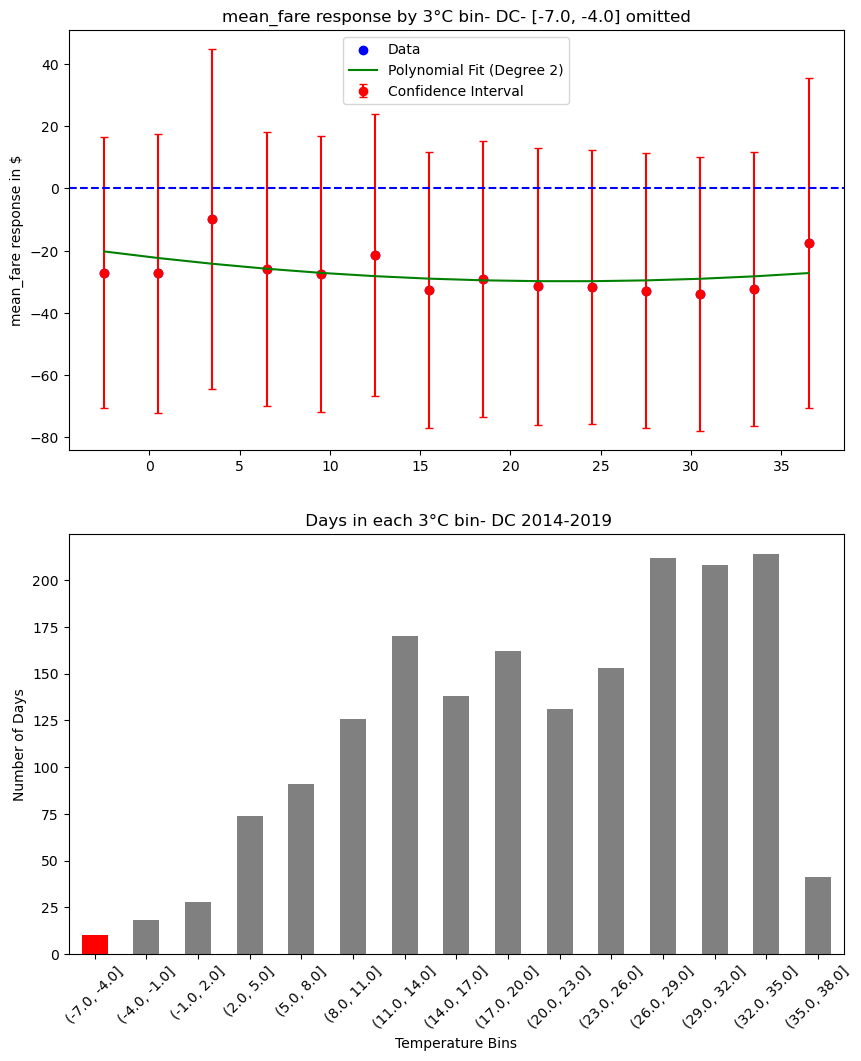

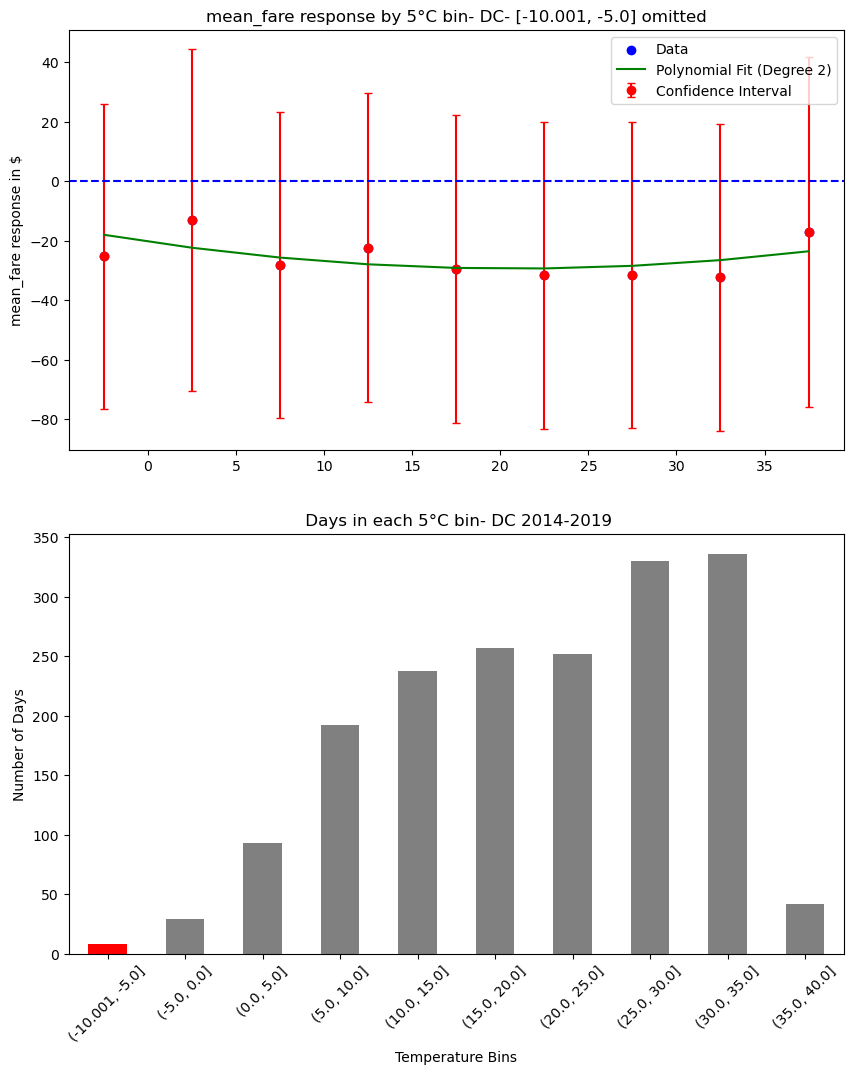

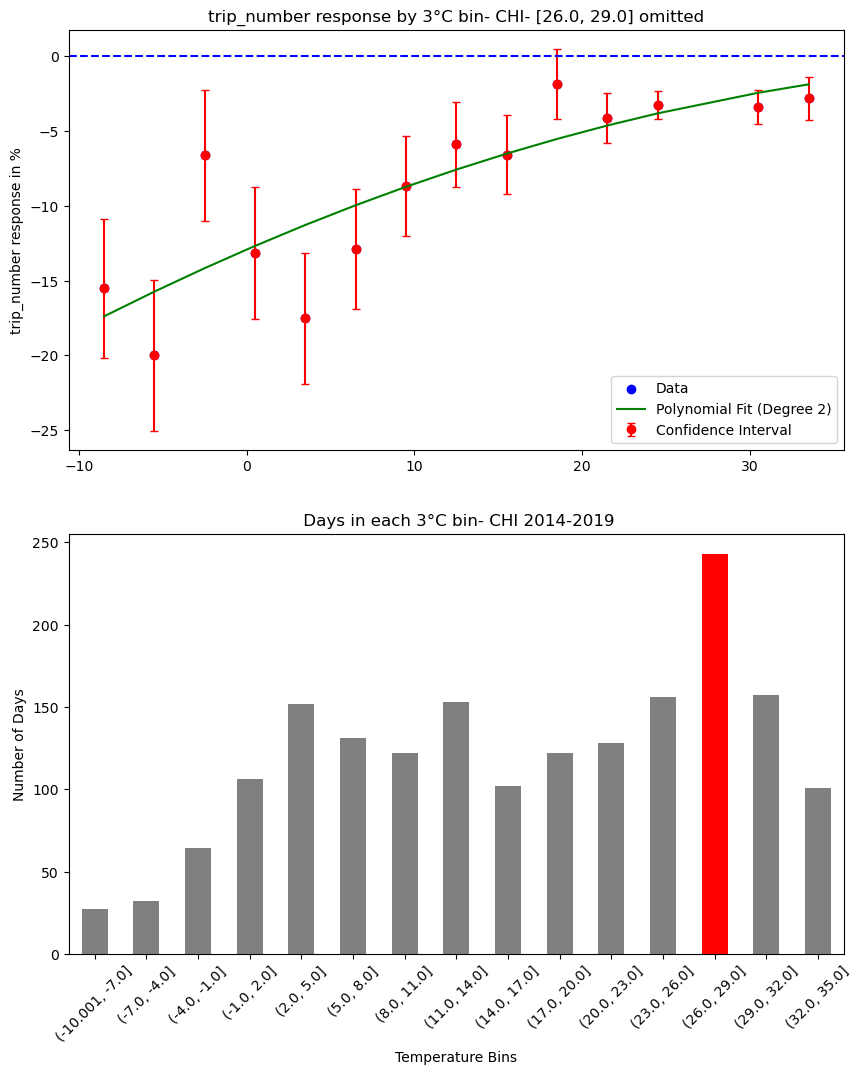

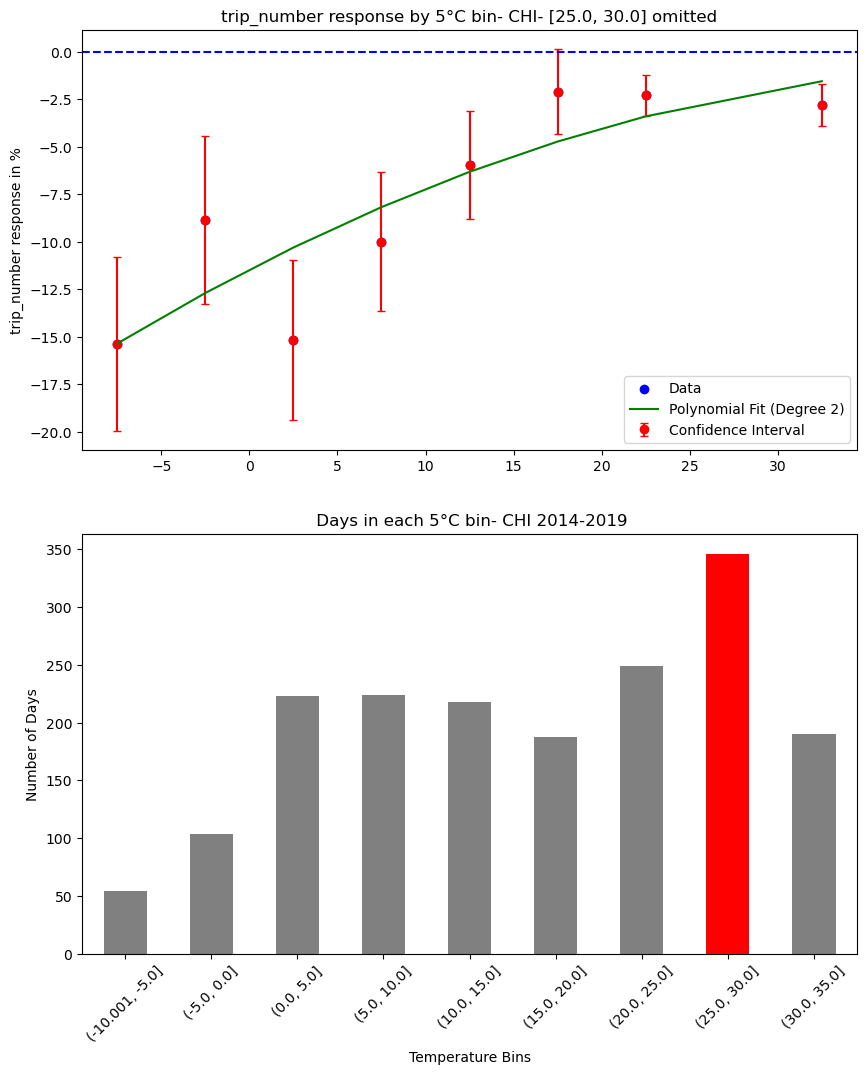

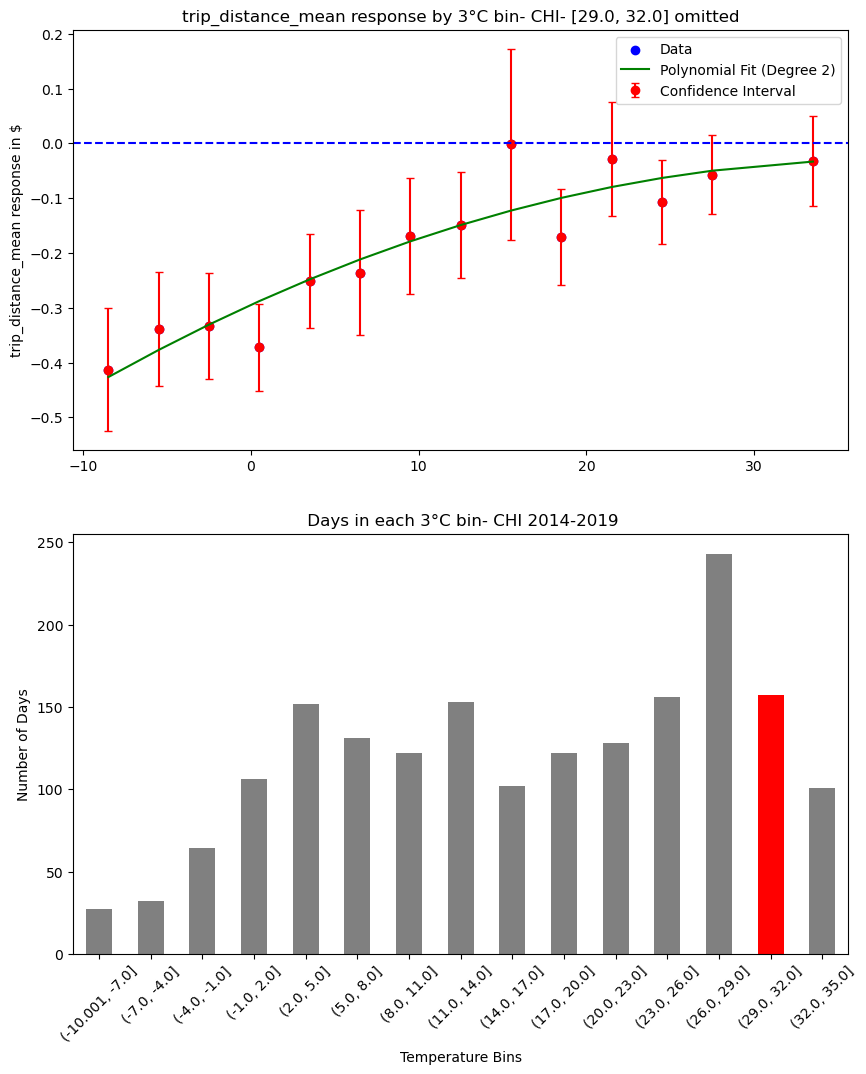

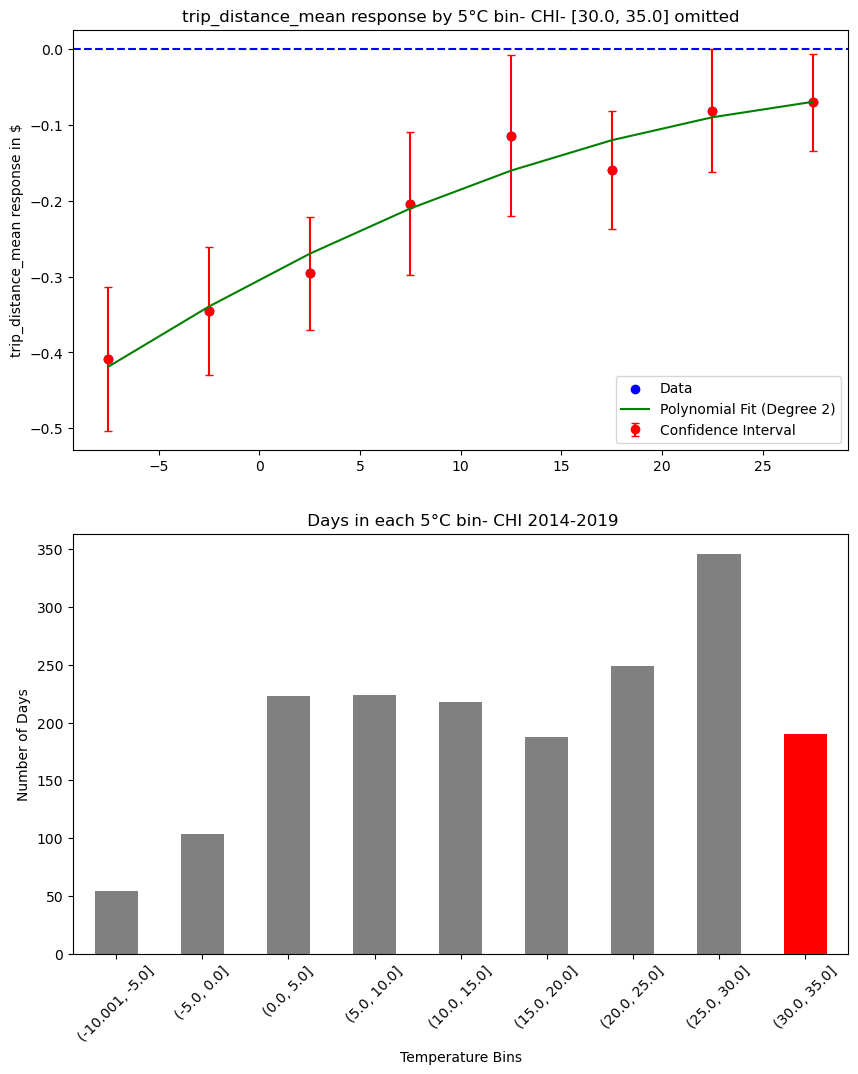

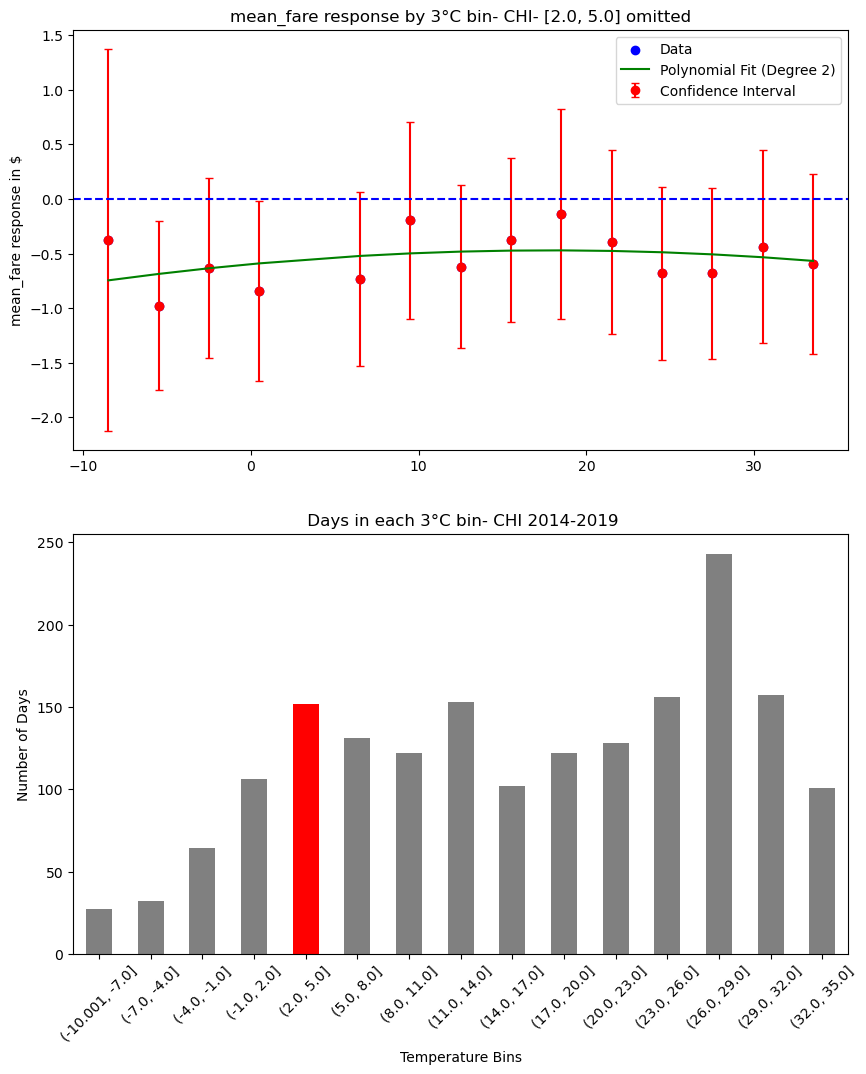

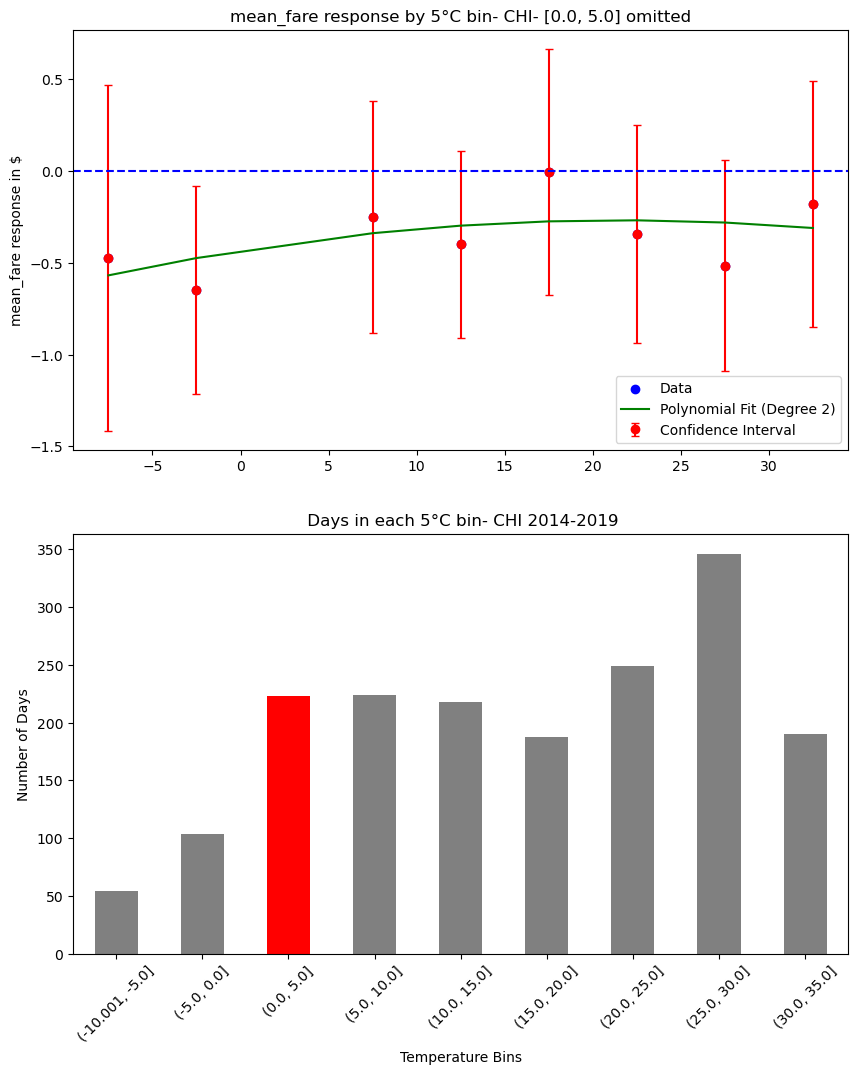

In [53]:
cities = ["NYC","DC","CHI"]
outcomes = ["trip_number","trip_distance_mean","mean_fare"]
temp_bin_sizes = [3,5]


for city in cities:
    for outcome in outcomes:
        for temp_bin_size in temp_bin_sizes:
            binned_regression_plots(city, outcome, temp_bin_size)